In [26]:
import splitfolders
from collections import Counter
import matplotlib.pyplot as plt
import random
from PIL import Image
import cv2
import numpy as np
import os
import time
from tqdm import tqdm

In [27]:
import torch, torchvision as tv, torch.optim as optim, copy
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.models as models
import torchvision.transforms.functional as F
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR

In [28]:
from pathlib import Path

In [29]:
from monai.data import CacheDataset
from monai.transforms import (
    Compose,LoadImaged, EnsureChannelFirstd, RandSpatialCropd, RandFlipd, RandAffined,
    Rand2DElasticd, RandGaussianNoised, RandBiasFieldd, RandHistogramShiftd,
    RandZoomd, RandRotate90d, NormalizeIntensityd, Resized, CenterSpatialCropd,
    RandGaussianSmoothd, RandShiftIntensityd, RandCoarseDropoutd, ToTensord, Lambdad
)

In [30]:
# Split the Data/train folder into train, val, and test subfolders
splitfolders.ratio(
    input="./extra_datasets/Dataset1", # Input folder with class subfolders
    output="./Data",      # Output folder where train/val/test folders will be created
    seed=43,               # For reproducibility
    ratio=(0.8, 0.1, 0.1), # 80% train, 10% val, 10% test
    group_prefix=None      # Default: no grouping
#    move = True         # files will not copy rather move
)

Copying files: 7023 files [00:03, 1966.37 files/s]


Understanding data - EDA

In [31]:
def count_images_in_directory(base_path):
    """Counts images in subfolders for train, val, and test splits."""
    splits = ['train', 'val', 'test']
    class_counts = {}
    for split in splits:
        split_path = os.path.join(base_path, split)
        if not os.path.exists(split_path):
            print(f"Warning: {split_path} does not exist. Skipping.")
            continue

        class_counts[split] = {}
        for class_name in os.listdir(split_path):
            class_path = os.path.join(split_path, class_name)
            if os.path.isdir(class_path):
                num_images = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))])
                class_counts[split][class_name] = num_images
    return class_counts

base_data_path = 'Data'
image_counts = count_images_in_directory(base_data_path)

print("\n--- Summary of Image Counts ---")
for split, counts in image_counts.items():
    total_split_images = sum(counts.values())
    print(f"{split.upper()} Set Total: {total_split_images} images ----")
    for class_name, count in counts.items():
        print(f"  {class_name}: {count} images")



--- Summary of Image Counts ---
TRAIN Set Total: 5617 images ----
  pituitary: 1405 images
  healthy: 1600 images
  glioma: 1296 images
  meningioma: 1316 images
VAL Set Total: 701 images ----
  pituitary: 175 images
  healthy: 200 images
  glioma: 162 images
  meningioma: 164 images
TEST Set Total: 705 images ----
  pituitary: 177 images
  healthy: 200 images
  glioma: 163 images
  meningioma: 165 images


In [32]:
# Function to load and visualize an image properties
def inspect_image(image_path, label):
    if not os.path.exists(image_path):
        print(f"Error: Image not found at {image_path}")
        return

    img = cv2.imread(image_path)

    if img is None:
        print(f"Error: Could not load image from {image_path}. Check file integrity.")
        return

    print(f"\n--- Inspecting {label} Image: {os.path.basename(image_path)} ---")
    print(f"Image Shape (Height, Width, Channels): {img.shape}")
    print(f"Image Data Type: {img.dtype}")
    # You can also print min/max pixel values to check range
    print(f"Min pixel value: {np.min(img)}")
    print(f"Max pixel value: {np.max(img)}")

# Inspect a healthy image
inspect_image("Data/train/healthy/0000.jpg", "Healthy") # (225, 225, 3)

# Inspect a glioma image (representing a tumor)
inspect_image("Data/train/glioma/0000.jpg", "Glioma (Tumor)") # (512, 512, 3)


--- Inspecting Healthy Image: 0000.jpg ---
Image Shape (Height, Width, Channels): (225, 225, 3)
Image Data Type: uint8
Min pixel value: 0
Max pixel value: 255

--- Inspecting Glioma (Tumor) Image: 0000.jpg ---
Image Shape (Height, Width, Channels): (512, 512, 3)
Image Data Type: uint8
Min pixel value: 0
Max pixel value: 255


In [33]:
data_dir = "data/train"
dataset = datasets.ImageFolder(root=data_dir, transform=None)
# print("Classes found:", dataset.classes)
# print("Class to index mapping:", dataset.class_to_idx)
# print("Total images:", len(dataset))
labels = [label for _, label in dataset.imgs]
counts = Counter(labels)
# print("Class label counts:", counts)
class_names = dataset.classes
print({class_names[k]: v for k, v in counts.items()})

{'glioma': 1296, 'healthy': 1600, 'meningioma': 1316, 'pituitary': 1405}


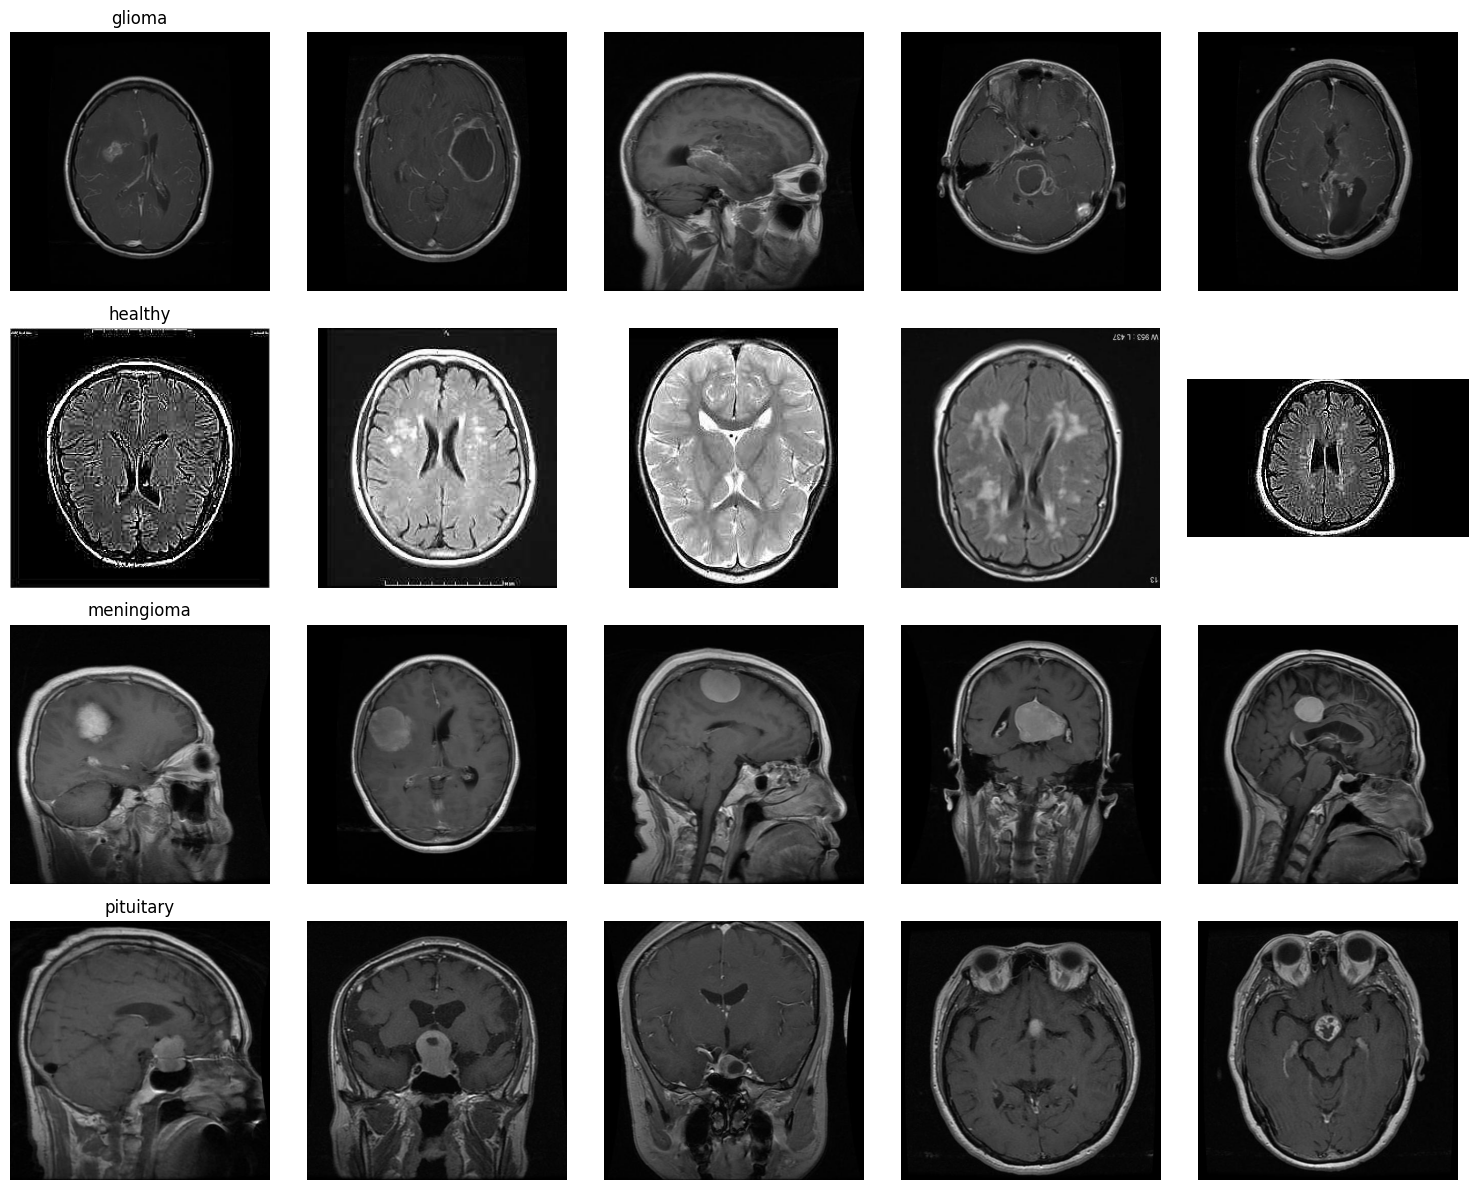

In [34]:
# Visualize Sample Images from Each Class
def visualize_samples(dataset, num_samples=3):     # visualize random 3 sample from all the classes
    fig, axes = plt.subplots(len(dataset.classes), num_samples, figsize=(num_samples * 3, len(dataset.classes) * 3))
    for cls_idx, cls_name in enumerate(dataset.classes):
        indices = [i for i, (_, label) in enumerate(dataset.imgs) if label == cls_idx]
        selected = random.sample(indices, num_samples)
        for j, idx in enumerate(selected):
            path, _ = dataset.imgs[idx]
            img = Image.open(path).convert("RGB")
            axes[cls_idx, j].imshow(img)
            axes[cls_idx, j].axis("off")
            if j == 0:
                axes[cls_idx, j].set_title(cls_name)
    plt.tight_layout()
    plt.show()

visualize_samples(dataset, num_samples=5)


Resolution stats (h×w): [168 150] [1446 1920] [448.48566851 446.25529642]


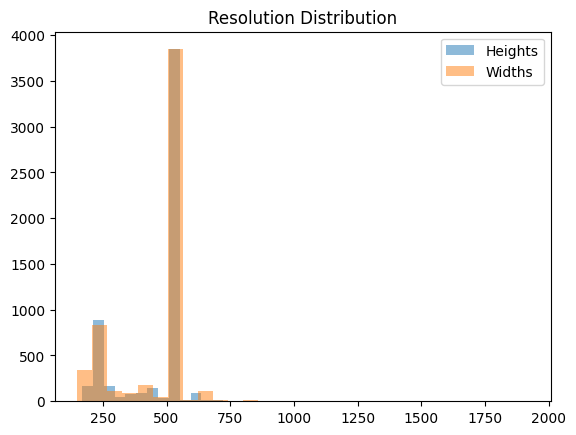

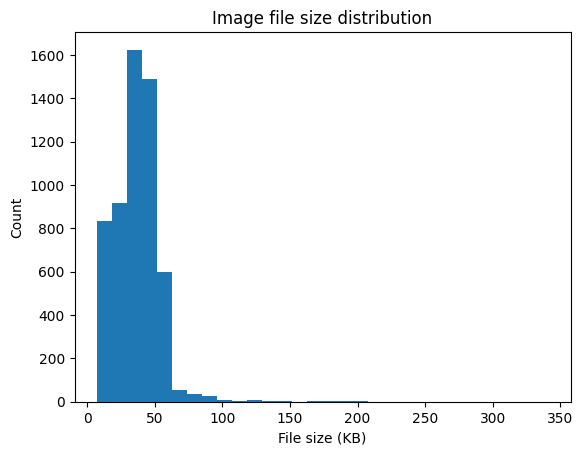

In [35]:
# Check Resolution and Size Consistency
resolutions = []
file_sizes = []

for path, _ in dataset.imgs:
    img = cv2.imread(path)
    h, w = img.shape[:2]
    resolutions.append((h, w))
    file_sizes.append(os.path.getsize(path))

res_arr = np.array(resolutions)
print("Resolution stats (h×w):", res_arr.min(axis=0), res_arr.max(axis=0), res_arr.mean(axis=0))

plt.hist([h for h, w in resolutions], bins=30, alpha=0.5, label="Heights")
plt.hist([w for h, w in resolutions], bins=30, alpha=0.5, label="Widths")
plt.legend(); plt.title("Resolution Distribution")
plt.show()

plt.hist([fs / 1e3 for fs in file_sizes], bins=30)
plt.xlabel("File size (KB)"); plt.ylabel("Count")
plt.title("Image file size distribution")
plt.show()


DATA Preprocessing ---

TRANSFORM PIPELINES

In [36]:
## basic transformations ---
# train_tf = transforms.Compose([
#     transforms.Resize(256),                          # fix width variability
#     transforms.RandomResizedCrop(224, scale=(0.8,1)),# random zoom crop
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomRotation(degrees=15),
#     transforms.ColorJitter(brightness=.15,
#                            contrast=.15),
#     transforms.ToTensor(),
#     transforms.Normalize(mean, std),
# ])
# val_tf = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean, std),
# ])
## ---

In [37]:
# MONAI standard transformations ---
from Extra_transform import to_single_channel # defined it in separate file so that worker threads created by DataLoader can import it parallel |

train_tf = Compose([
    LoadImaged(keys="image"), # LoadImaged reads the PNG/JPEG, returns a NumPy/torch array, and attaches metadata
    EnsureChannelFirstd(keys="image", strict_check=False),
    # MONAI uses CHW. So Converting [H × W × C] → [C × H × W] for PyTorch kernels so PyTorch sees “channel first” => CHW order expected by EfficientNet. But in MRI it is already grayscale so this step is of no use
    Lambdad(keys="image", func=to_single_channel),  # it is the dict lamda func acting on 'image'key which means out the across the channel dimension (dim 0), collapsing [C, H, W] → [H, W] while re-adding a singleton channel so the output is [1, H, W] bcz of keepdim=True
    RandSpatialCropd(keys="image", roi_size=(256, 256), random_size=False),
    # Crops a random 256 × 256 patch (no resize) => gives position variety while preserving tumour context.
    RandFlipd(keys="image", prob=0.5, spatial_axis=1),
    # 50% chance left ↔ right flip along x-axis => Brain is roughly L/R symmetric; doubles data without clinical distortion.
    RandRotate90d(keys="image", prob=0.5, max_k=3),
    # random 0/90/180/270° rotation => Simulates different head orientations from scanners and PACS viewers
    RandAffined(keys="image", prob=0.3, rotate_range=0.08, shear_range=0.04),
    # Small random rotation (±4.5°), shear, translate. Mimics patient's head tilt & minor slice angulation; encourages geometric robustness
    Rand2DElasticd(keys="image", prob=0.2, spacing=(32, 32), magnitude_range=(2, 5)),
    # Non-linear elastic warp/Rubber-sheet warp (jelly-like).(magnitude 2–5 px) => Models patient motion / soft-tissue deformation / interpolation artefacts seen in multi-vendor scans.
    RandBiasFieldd(keys="image", prob=0.3),
    # Applies smooth multiplicative bias field => Replicates RF-coil inhomogeneity—common MRI artefact that shifts intensity across slice.
    # [ie Imagine photographing a page under a desk lamp: the centre is brighter, corners dimmer.  Bias-field augmentation teaches the model that the “letter shapes” (tumours) matter, not the lamp gradient.]
    RandGaussianNoised(keys="image", prob=0.2, std=0.01),
    # Adds Gaussian noise σ = 0.01 => Matches grain produced by low-SNR sequences or accelerated scans.
    RandHistogramShiftd(keys="image", prob=0.3, num_control_points=5),
    # Randomly bend the grey-level curve ie. move grey-level histogram control points => Simulates different window/level presets and vendor contrast curves.
    RandShiftIntensityd(keys="image", offsets=0.1, prob=0.3),
    # Uniform ±0.1 shift of all voxel intensities (brightness tweak) => Covers global brightness drift (scanner calibration).
    RandCoarseDropoutd(keys="image", holes=1, max_holes=3,  # Cuts out 1-3 random 32 × 32 squares
                       spatial_size=(32, 32), prob=0.15),
    # “Cut-Mix” style occlusion forces model to use wider context, not one hotspot.
    RandGaussianSmoothd(keys="image", sigma_x=(0.5, 1.5), prob=0.1),
    # Random blur (σ 0.5–1.5 px) => Imitates slice-thickness blur or patient motion; makes model blur-tolerant.
    RandZoomd(keys="image", prob=0.2, min_zoom=0.9, max_zoom=1.2),
    # Random zoom 0.9–1.2x => Handles FOV changes between scanners or axial vs oblique reconstructions.
    Resized(keys="image", spatial_size=(256,256), mode="nearest"),
    ToTensord(keys="image"),
    NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    # Z-score per channel (brain mask) => Removes scanner-specific intensity scale so network learns anatomy, not brightness.
    # ie Turns raw intensities into zero-mean, unit-std per slice

    # tv.transforms.Normalize(mean=(0.485,), std=(0.229,)) <- we are using the 'd' type normalisation from monai
    # ImageNet mean/std ensure compatibility with pretrained EfficientNet ie mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225) but as we are dealing with grayscale so only 1 channel is given
])
# the 'd' in every transformation name signifies that the transformation operates on a dictionary of data instead of a bare Tensor like {"image": Tensor, "label": Tensor, …}

val_test_tf = Compose([
    # EnsureChannelFirstd(keys="image", channel_dim=0),
    LoadImaged(keys="image"),
    EnsureChannelFirstd(keys="image", strict_check=False),
    Lambdad(keys="image", func=to_single_channel),
    CenterSpatialCropd(keys="image", roi_size=(224, 224)),
    # centre crop -- we can otherwise resize to 224x224 but most medical CV papers keep the classic resize-then-centre-crop protocol
    # bcz 1. imagenet model was pretrained on 224 × 224 images 2. cropping removes the border artefacts safely
    Resized(keys="image", spatial_size=(256, 256)),  # long edge → 256
    ToTensord(keys="image"),
    NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True)
    # hand-off to PyTorch tensor and ImageNet stats (1-channel version)
])

In [38]:
def sanity_check(loader, device="mps", n_batches=2):
    '''loader pull two real batches with workers running, moves them to the GPU, and times the whole trip so you know that (a) the pipeline doesn’t crash once workers/GPU enter the picture and (b) num_workers choice is feeding the GPU fast enough.'''

    t0 = time.perf_counter()

    for b, batch in enumerate(loader):          # ← receive the dict
        if b >= n_batches:
            break           # don’t run full epoch

        x = batch["image"]
        y = batch["label"]
        print(f"Batch {b}: tensor {x.shape} dtype={x.dtype} device={x.device}")
        assert x.shape[1:] == (1, 256, 256), "Wrong spatial dims or channels!"

        # push once to confirm MPS works
        x = x.to(device)
        y = y.to(device)

    dt = time.perf_counter() - t0
    imgs_per_sec = (n_batches * loader.batch_size) / dt
    print(f"✓ {n_batches * loader.batch_size} images OK "
          f"@ {imgs_per_sec:,.0f} img/s")

def show_augmented_samples(loader, n=4):
    batch = next(iter(loader))                 # ← one dict
    imgs   = batch["image"]                    # Tensor [B,1,256,256]
    labels = batch["label"]                    # Tensor [B]

    # pick first n images
    n = min(n, imgs.size(0))
    fig, ax = plt.subplots(1, n, figsize=(3*n, 3))
    fig.suptitle('Results after augmentation')
    for i in range(n):
        # remove channel dim for display, move to CPU
        img = imgs[i].cpu().squeeze(0)         # [H,W]
        ax[i].imshow(F.to_pil_image(img), cmap="gray")
        ax[i].set_title(f"fig {i}: label = {labels[i].item()}")
        ax[i].axis("off")
    plt.show()

In [39]:
# ── DATASETS & LOADERS ──────────────────────────────────────────────
    # ********** this dataloader can't be used with MONAI because ImageFolder feeds a PIL Image,
    # but every transform in the list ends with d, which tells MONAI “I’m a dictionary transform—expect
    # a Python dict like {"image": image, "label": …}.". *****************
    #
    # def make_loader(split, tf, shuffle):
    #     ds = tv.datasets.ImageFolder(ROOT / split, transform=tf)
    #     return DataLoader(ds, batch_size=BATCH,
    #                       shuffle=shuffle,
    #                       num_workers=NUM_W,
    #                       pin_memory=False)
    #
    #
    # train_loader = make_loader("train", train_tf, True)
    # val_loader = make_loader("val", val_test_tf, False)
    # test_loader = make_loader("test", val_test_tf, False)
    #
    # print(f"Train imgs: {len(train_loader.dataset)}  "  # type: ignore[call-arg]
    #       f"Val imgs: {len(val_loader.dataset)}  "  # type: ignore[call-arg]
    #       f"Test imgs: {len(test_loader.dataset)}")  # type: ignore[call-arg]
    #***************
    # ── QUICK SANITY CHECK ──────────────────────────────────────────────
    # Fetch one mini-batch and push it through MPS to verify shapes/speeds.
    # x, y = next(iter(train_loader))
    # print("Batch:", x.shape, y.shape, "→ device:", DEVICE)
    # x = x.to(DEVICE);
    # y = y.to(DEVICE)

In [40]:
'''
1. MONAI specific prebuilt data augmentation functions (for training only)
2. Standardizing all the images to 224x224 pixels and normalizing the utf-8 (8bit => 0-255) pixel values to 0-1
3.

'''
NUM_EPOCHS = 20
BATCH = 32  #32
NUM_W = 0  # tune to your CPU cores
DEVICE = torch.device("mps")

In [41]:
def get_file_list_for_split(split_path):
    # files = [{"image": f} for f in (split_path / "train").rglob("*.jpg")]  # dict -> {"image": Tensor, …}
    # print(*files[0:5])
    classes = sorted(d for d in split_path.iterdir() if d.is_dir())
    print(classes)
    label_map = {cls.name: idx for idx, cls in enumerate(classes)}
    print(label_map)
    files = []
    for cls in classes:
        for f in cls.rglob("*.jpg"):                  # or *.jpg
            files.append({
                "image": str(f),
                "label": label_map[cls.name]          #  ←─ add integer label
            })

    print(files[0:5])
    return files
# Define your data paths
ROOT = Path("Data")
train_path = ROOT / "train"
val_path = ROOT / "val"
test_path = ROOT / "test"

# Create separate lists for each split
train_files = get_file_list_for_split(train_path)
val_files = get_file_list_for_split(val_path)
test_files = get_file_list_for_split(test_path)

print(f"Found {len(train_files)} training files.")
print(f"Found {len(val_files)} validation files.")
print(f"Found {len(test_files)} test files.")

[PosixPath('Data/train/glioma'), PosixPath('Data/train/healthy'), PosixPath('Data/train/meningioma'), PosixPath('Data/train/pituitary')]
{'glioma': 0, 'healthy': 1, 'meningioma': 2, 'pituitary': 3}
[{'image': 'Data/train/glioma/0071.jpg', 'label': 0}, {'image': 'Data/train/glioma/0717.jpg', 'label': 0}, {'image': 'Data/train/glioma/1409.jpg', 'label': 0}, {'image': 'Data/train/glioma/0703.jpg', 'label': 0}, {'image': 'Data/train/glioma/0065.jpg', 'label': 0}]
[PosixPath('Data/val/glioma'), PosixPath('Data/val/healthy'), PosixPath('Data/val/meningioma'), PosixPath('Data/val/pituitary')]
{'glioma': 0, 'healthy': 1, 'meningioma': 2, 'pituitary': 3}
[{'image': 'Data/val/glioma/0273.jpg', 'label': 0}, {'image': 'Data/val/glioma/0267.jpg', 'label': 0}, {'image': 'Data/val/glioma/0307.jpg', 'label': 0}, {'image': 'Data/val/glioma/1031.jpg', 'label': 0}, {'image': 'Data/val/glioma/0449.jpg', 'label': 0}]
[PosixPath('Data/test/glioma'), PosixPath('Data/test/healthy'), PosixPath('Data/test/menin

In [42]:
train_ds = CacheDataset(train_files, transform=train_tf, num_workers=NUM_W, cache_rate=0.2)
# Compose some steps before the first Randomizable transform (e.g. LoadImage → EnsureChannelFirst → NormalizeIntensity) are executed and cached happens once (1st time and takes time)


Loading dataset: 100%|██████████| 1123/1123 [00:05<00:00, 218.06it/s]


In [43]:
# # finding the number of worker suitable
# import itertools, time
#
# def make_loader(ds, nw):
#     return DataLoader(ds,
#                       batch_size=32,
#                       shuffle=True,
#                       num_workers=nw,
#                       persistent_workers=nw > 0, # workers stay alive between epochs
#                       pin_memory=False) # ignored on Apple-silicon, silences warning
#
# def loader_fps(loader, n_batches=30):
#     t0 = time.perf_counter()
#     for _ in itertools.islice(loader, n_batches):
#         pass        # just iterate, no GPU work
#     return n_batches * loader.batch_size / (time.perf_counter() - t0)
#
# for nw in [0, 1, 2, 3, 4, 5]: # finding the sweetspot here for nw
#     fps = loader_fps(make_loader(train_ds, nw))
#     print(f"{nw} worker(s) → {fps:5.0f} images / second")
#
# # Got the output as (in my macbook pro M1)
# # images are small enough to fit comfortably in RAM, CacheDataset (0 workers) is faster
# # 0 worker(s) →    93 images / second  --> so proceeding with num_workers=0
# # 1 worker(s) →    62 images / second
# # 2 worker(s) →    63 images / second
# # 3 worker(s) →    51 images / second
# # 4 worker(s) →    41 images / second
# # 5 worker(s) →    40 images / second


In [44]:
train_loader = DataLoader(train_ds, batch_size=BATCH, num_workers=NUM_W)
# takes the cached tensors in "train_ds" every batch and applies the random transforms that come after the cache-point (RandFlip, RandBiasField, etc.) and stacks size of BATCH = 32 tensors into a batch
# If you skip CacheDataset, the whole Compose chain (deterministic + random) runs for every epoch.

<class 'monai.data.meta_tensor.MetaTensor'> torch.Size([1, 256, 256])
torch.Size([32, 1, 256, 256]) torch.Size([32])


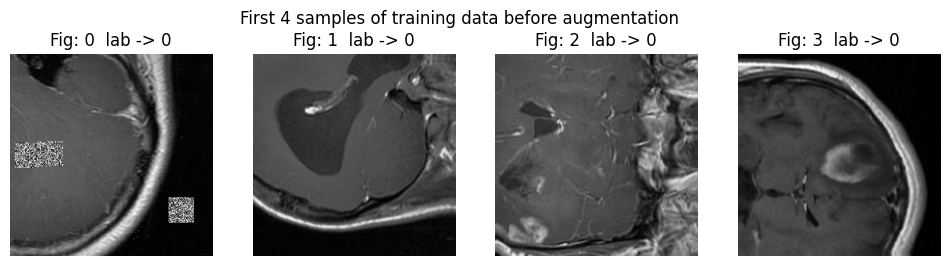

Batch 0: tensor torch.Size([32, 1, 256, 256]) dtype=torch.float32 device=cpu
Batch 1: tensor torch.Size([32, 1, 256, 256]) dtype=torch.float32 device=cpu
✓ 64 images OK @ 56 img/s


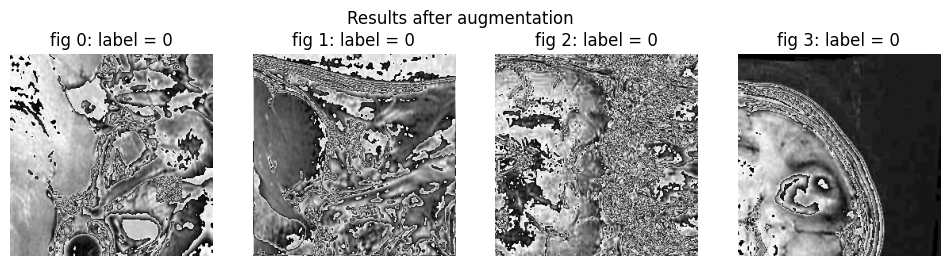

In [45]:
# ── Training dataset sanity check ──────────────────────────────────────────────
# Single-sample / first-batch peek
sample = train_ds[0]
print(type(sample["image"]), sample["image"].shape)  # expect ndarray, (H,W)
batch = next(iter(train_loader))
x     = batch["image"]               #   images tensor  [B, 1, 256, 256]
y     = batch["label"]               #   label tensor   [B]
print(x.shape, y.shape) # expect [B,1,224,224]

# First 4 samples
imgs  = batch["image"][:4]   # first 4 images
labs  = batch["label"][:4]

fig, ax = plt.subplots(1, 4, figsize=(12,3))
fig.suptitle('First 4 samples of training data before augmentation')
for i in range(4):
    pic = imgs[i,0].cpu()                     # remove channel dim
    ax[i].imshow(pic, cmap="gray")
    ax[i].set_title(f"Fig: {i}  lab -> {int(labs[i])}")
    ax[i].axis(False)
plt.show()

# Overall pipeline sanity check
sanity_check(train_loader)  # prints shape / speed => ✓ 64 images OK @ 70 img/s means 2 batches (as sanity_check has n_batches=2) of 32 image(batch size) is pulled and side-processed and pipeline speed is 70 img/sec
show_augmented_samples(train_loader)  # visual eyeball test

Loading dataset: 100%|██████████| 140/140 [00:01<00:00, 135.48it/s]


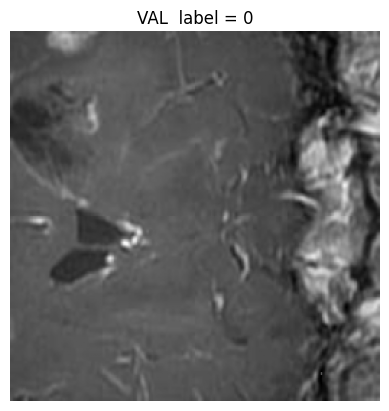

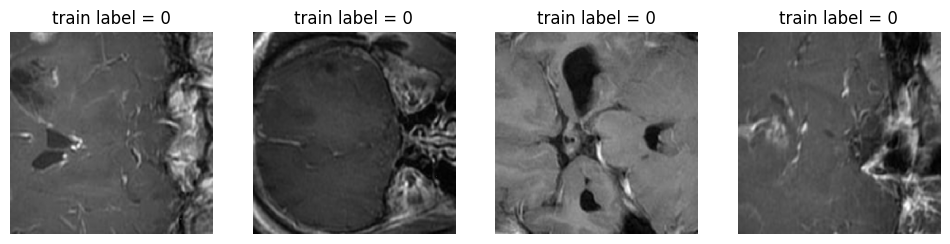

In [46]:
# ── Validation dataset sanity check ──────────────────────────────────────────────
val_ds = CacheDataset(val_files, transform=val_test_tf, num_workers=NUM_W, cache_rate=0.2)
# Compose some steps before the first Randomizable transform (e.g. LoadImage → EnsureChannelFirst → NormalizeIntensity) are executed and cached happens once (1st time and takes time)
val_loader = DataLoader(val_ds, batch_size=BATCH, num_workers=NUM_W)
val_batch = next(iter(val_loader))
v_img  = val_batch["image"][0, 0].cpu()    # [1,H,W] -> [H,W]
v_lab  = int(val_batch["label"][0])


plt.imshow(v_img, cmap="gray")
plt.title(f"VAL  label = {v_lab}")
plt.axis(False)
plt.show()
def show_augmented(loader, n=4):
    batch = next(iter(loader))
    imgs, labels = batch["image"], batch["label"]

    fig, ax = plt.subplots(1, n, figsize=(3*n, 3))
    for i in range(n):
        t = imgs[i, 0].cpu()
        # scale to 0-1 just for display
        disp = (t - t.min()) / (t.max() - t.min() + 1e-6)
        ax[i].imshow(disp, cmap="gray")
        ax[i].set_title(f"train label = {int(labels[i])}")
        ax[i].axis(False)
    plt.show()

show_augmented(val_loader, n=4)

# print(Counter(int(b["label"]) for b in train_ds.data))
# print(Counter(int(b["label"]) for b in val_ds.data))

Model Definition

In [47]:
# Load a pre-trained EfficientNet-B0
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

# # initial layer modification
original_first_layer = model.features[0][0]             # Get the original first convolution layer (3-ch)
# model.features[0] → the stem block in EfficientNet.[0] -> inside that block ie the first Conv2d (kernel size 3×3, in = 3, out = 32)

# Create a new convolution layer with 1 input channel
new_first_layer = nn.Conv2d(    ## motive:  [32, 3, 3, 3] -> [32, 1, 3, 3].
    in_channels=1, # single Grayscale input
    out_channels=original_first_layer.out_channels, # keeping network’s width identical, so later weights don’t need reshaping.
    kernel_size=original_first_layer.kernel_size,
    stride=original_first_layer.stride,
    padding=original_first_layer.padding,
    bias=(original_first_layer.bias is not None)
)
# Adapt the pre-trained weights from 3 channels to 1 channel by averaging them.
# This provides a better starting point than random initialization.
with torch.no_grad(): # don’t track gradients bcz we are taking pre-trained weights from the original model, averaging them, and copying them into your new layer. One time setup, nothing to learn
    new_first_layer.weight[:] = original_first_layer.weight.mean(dim=1, keepdim=True)
    # Replacing the original first layer with our new one
    model.features[0][0] = new_first_layer
    if original_first_layer.bias is not None: # in EfficientNet-B0 architecture the 1st layer bias=False though
        new_first_layer.bias.copy_(original_first_layer.bias)


# # final layer (classifier for 4-class output) modification
# Number of classes (glioma, healthy, meningioma, pituitary)
NUM_CLASSES = 4
# Get the number of input features for the classifier
num_filters_before_final_layer_output = model.classifier[1].in_features

# original final layer in EfficientNet-B0 is --> Sequential((0): Dropout(p=0.2, inplace=True), (1): Linear(in_features=1280, out_features=1000, bias=True))
# Replace the classifier with a new one for our 4 classes
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5, inplace=True), # on small medical datasets you might lower it to 0.1 to prevent under-fitting.
    nn.Linear(num_filters_before_final_layer_output, NUM_CLASSES)
)


Fine Tuning

In [48]:
# Now, we will freeze the feature layers for transfer learning,leaving the new classifier and the new first conv layer trainable.
for param in model.parameters():
    param.requires_grad = False # turn off every single parameter (weights and biases) in the entire EfficientNet-B0 model as 'requires_grad' flag is the signal for PyTorch's autograd engine.

# Unfreeze the first conv layer and the final classifier
for param in model.features[0][0].parameters(): # first
    param.requires_grad = True
for param in model.classifier.parameters(): # last
    param.requires_grad = True

# # Unfreeze the last MBConv block as well (if VRAM permits) which gives the network one high-level block to specialise on tumour textures
for param in model.features[-1].parameters():
    param.requires_grad = True

# # --- BatchNorm helper ---------------------------------
# for m in model.modules():
#     if isinstance(m, nn.BatchNorm2d):
#         m.weight.requires_grad = False   # keep gamma & beta frozen
#         m.bias.requires_grad = False
#         m.training = True               # BUT still track new stats
# # ------------------------------------------------------

# Move the model to your Mac's GPU
DEVICE = torch.device("mps")
model = model.to(DEVICE)
# model = torch.compile(model) # compile once, use every epoch -> gives ~10-20% boost in mps
print("Model successfully adapted for 1-channel input and 4-class output.")

Model successfully adapted for 1-channel input and 4-class output.


In [49]:
# --- 2. TRAINING COMPONENTS ───────────────────────────────────────────

# Loss function for multi-class classification

# there is mildly imbalanced dataset glioma: 1471, healthy: 1823, meningioma: 1498, pituitary: 1601 so we can experiment with focal loss here if that improves performance.
USE_FOCAL = False            # flip to True if classes still imbalanced
if USE_FOCAL:
    class FocalLoss(nn.Module):
        def __init__(self, gamma=2.0):
            super().__init__()
            self.gamma = gamma
        def forward(self, logits, target):
            p = torch.softmax(logits, 1)
            pt = p.gather(1, target.unsqueeze(1)).squeeze()
            return (-((1-pt)**self.gamma) * torch.log(pt)).mean()
    criterion = FocalLoss()
else:
    criterion = nn.CrossEntropyLoss()

# # Optimizer: We pass all model parameters since we want to fine-tune the first layer as well as train the classifier.
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                        lr=3e-4, weight_decay=1e-3)

# # Learning rate scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=10)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer,
#     mode='min',      # Reduce LR when the metric has stopped decreasing
#     factor=0.1,      # New LR = LR * factor
#     patience=3,      # Number of epochs with no improvement to wait
#     verbose=True     # Print a message when the LR is updated
# )

training helpers (Implementation of DRY principle)

In [50]:
def run_epoch(model, dataloader, criterion, optimizer=None, device="cpu", grad_clip_value=None):
    """
    A more advanced function to run one epoch of training or validation.

    Args:
        model (nn.Module): The PyTorch model to train/evaluate.
        dataloader (DataLoader): The data loader for the current epoch.
        criterion: The loss function.
        optimizer (Optimizer, optional): The optimizer. If None, runs in validation mode.
        device (str): The device to run on ('mps', 'cuda', 'cpu').
        grad_clip_value (float, optional): The value to clip gradients at. If None, no clipping.
    """
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Wrap the dataloader with tqdm for a progress bar
    progress_bar = tqdm(dataloader, desc="Train" if is_train else "Validate", leave=False)

    # Enable/disable gradients based on whether we are training
    with torch.set_grad_enabled(is_train):
        for batch in progress_bar:
            inputs, labels = batch["image"].to(device), batch["label"].to(device)

            # Forward pass with Automatic Mixed Precision
            with torch.amp.autocast(device_type=str(device), dtype=torch.float16):
                logits = model(inputs)
                loss = criterion(logits, labels)

            # --- Training-specific steps ---
            if is_train:
                optimizer.zero_grad()
                loss.backward()

                # Optional: Gradient Clipping
                if grad_clip_value:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_value)

                optimizer.step()

            # --- Statistics Calculation (for both train and val) ---
            preds = logits.argmax(dim=1)
            total_loss += loss.item() * labels.size(0)
            correct_predictions += (preds == labels).sum().item()
            total_samples += labels.size(0)

            # Update the progress bar with live metrics
            current_loss = total_loss / total_samples
            current_acc = correct_predictions / total_samples
            progress_bar.set_postfix(loss=f"{current_loss:.4f}", acc=f"{current_acc:.4f}")

    final_loss = total_loss / total_samples
    final_acc = correct_predictions / total_samples

    return final_loss, final_acc

Training loop

In [51]:
# --- Check for a checkpoint and load it ---
CHECKPOINT_FILE = "training_checkpoint.pth"

start_epoch = 0
best_val_acc = 0.0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

if os.path.exists(CHECKPOINT_FILE):
    print(f"Checkpoint found! Resuming training from {CHECKPOINT_FILE}")
    checkpoint = torch.load(CHECKPOINT_FILE)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    best_val_acc = checkpoint['best_val_acc']
    history = checkpoint['history'] # Restore history if you saved it

    print(f"   -> Resuming from epoch {start_epoch} with best validation accuracy of {best_val_acc:.4f}")
else:
    print("No checkpoint found. Starting training from scratch.")


Checkpoint found! Resuming training from training_checkpoint.pth
   -> Resuming from epoch 10 with best validation accuracy of 0.2953


In [52]:
print("Starting training...")
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()

    # --- Train for one epoch ---
    train_loss, train_acc = run_epoch(
        model, train_loader, criterion, optimizer, device=DEVICE, grad_clip_value=1.0
    )

    # --- Validate the model ---
    val_loss, val_acc = run_epoch(
        model, val_loader, criterion, optimizer=None, device=DEVICE
    )

    # --- Update history and learning rate ---
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # The scheduler step should be called after the optimizer step.
    # For CosineAnnealingLR, it's typically called each epoch.
    scheduler.step()

    # --- Save the best model ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        # best_model_weights = copy.deepcopy(model.state_dict()) # saving the model's weights temporarily
        # we will use checkpoint rather below
        print(f"\nEpoch {epoch+1}: New best model found! Val Acc: {val_acc:.4f}. Saving checkpoint...")

    # print the model status with epoch
    epoch_duration = time.time() - epoch_start_time
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
          f"LR: {optimizer.param_groups[0]['lr']:.6f} | "
          f"Duration: {epoch_duration:.2f}s")

    # Create a dictionary to hold everything we need to resume
    checkpoint = {
        'epoch': epoch + 1,  # Save the *next* epoch number to start from
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val_acc': best_val_acc,
        'history': history # Optional: save the training history too
    }
    # --- SAVE BEST MODEL WEIGHTS TILL NOW ---------------------------------------------
    torch.save(checkpoint, CHECKPOINT_FILE)
    torch.save(model.state_dict(), 'brain_tumor_classifier_best.pth') # Keep saving the best weights file too
    print("\n Best model weights saved to brain_tumor_classifier_best.pth")

# Final status update
training_duration = time.time() - start_time
print(f"\n Training finished in {training_duration / 60:.2f} minutes.")
print(f" \nBest Validation Accuracy: {best_val_acc:.4f}")


Starting training...


KeyboardInterrupt: 